# Volume 3: ARMA Models
    Benj McMullin
    Math 405
    3/19/2024

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd
from itertools import product

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0,:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

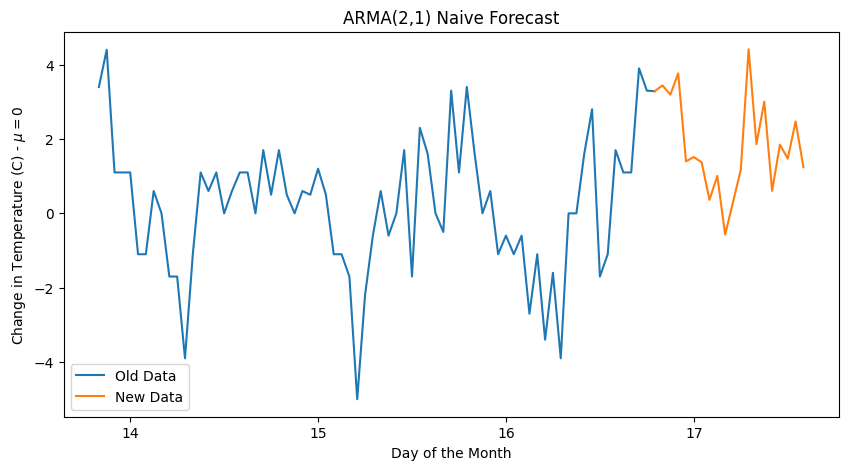

In [3]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # Read in the data
    weather = np.load(file)
    
    # Get the differences in the days
    z_i = np.diff(weather)
    k = len(z_i) - 1
    
    # Initialize variables
    c = 0  # Constant term
    phi_i = 0.5  # Coefficient for the AR component
    theta_j = 0.1  # Coefficient for the MA component
    eps_i = np.random.normal(0, 1, k)  # Random noise
    
    # Iterate
    pred_z = []  # List to store forecasted temperature changes
    pred_t = []  # List to store forecasted time points
    for t in range(k, k + n):
        # Get new epsilon
        eps_i = np.append(eps_i, np.random.normal(0, 1))
        
        # Calculate AR component
        ar = np.sum([phi_i * z_i[t - i] for i in range(p)])
        
        # Calculate MA component
        ma = np.sum([theta_j * eps_i[t - j] for j in range(q)])
        
        # Calculate new temperature change
        z_i = np.append(z_i, c + ar + ma + eps_i[t])
        pred_z.append(c + ar + ma + eps_i[t])
        pred_t.append(t + 1)
    
    # Plot
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(z_i[:-len(pred_t) + 1], label='Old Data')  # Plot original data
    plt.plot(pred_t, pred_z, label='New Data')  # Plot forecasted data
    plt.title(f'ARMA({p},{q}) Naive Forecast')  # Set title
    plt.xlabel('Day of the Month')  # Set x-axis label
    plt.ylabel(r'Change in Temperature (C) - $\mu = 0$')  # Set y-axis label
    plt.xticks([4 + 24 * i for i in range(5)], [14, 15, 16, 17, 18])  # Set x-axis ticks
    plt.legend()  # Show legend
    plt.plot()  # Display plot

# Call the function to execute
arma_forecast_naive()

## Problem 2

In [4]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # Load in the file
    weather = np.load(filename)

    # Get F, Q, and H from the state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # Get the difference in the data
    z_i = np.diff(weather)

    # Get the means and covariances from the Kalman Filter
    mus, covs = kalman(F, Q, H, z_i - np.ones_like(z_i) * mu)

    # Calculate the log-likelihood using Equation 25.18
    likelihood = np.sum([norm.logpdf(z_i[i], loc=H @ mus[i] + mu, scale=np.sqrt(H @ covs[i] @ H.T)) for i in range(len(z_i))])

    return likelihood

# Call the function to calculate the log-likelihood
arma_likelihood()

-1375.1805469978774

## Problem 3

In [5]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # Load in data, get differences, and get size
    weather = np.load(filename)
    z_i = np.diff(weather)
    n = len(z_i)
    
    # Define the objective function f from the ARMA likelihood
    def f(x):
        try:
            return -1 * arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
        except np.linalg.LinAlgError:
            return np.inf

    # Get all combinations of p and q
    pq = list(product(range(1, p_max+1), range(1, q_max+1)))
    
    # Initialize variables to store best AIC and corresponding model parameters
    best_aic = np.inf
    best_p = None
    best_q = None
    best_sol = None

    # Iterate over all combinations of p and q
    for p, q in pq:
        # Initialize starting values for the optimization
        x0 = np.zeros(p + q + 2)
        x0[-2] = z_i.mean()  # Set initial guess for mean
        x0[-1] = z_i.std()   # Set initial guess for standard deviation
        
        # Optimize the objective function
        sol = minimize(f, x0, method='SLSQP').x
        
        # Calculate the AIC criterion
        k = p + q + 2  # Number of parameters
        curr_aic = 2 * k * (1 + (k + 1) / (n - k)) + 2 * f(sol)
        
        # Update best AIC and corresponding model parameters if current AIC is lower
        if curr_aic < best_aic:
            best_aic = curr_aic
            best_p = p
            best_q = q
            best_sol = sol
        
    # Return the best solution
    return best_sol[:best_p], best_sol[best_p:best_p+best_q], best_sol[-2], best_sol[-1]

# Call the function to identify the best ARMA model parameters
model_identification(filename='weather.npy', p_max=4, q_max=4)

C:\Users\benja\AppData\Local\Temp\ipykernel_16828\850808066.py:29: RuntimeWarning: invalid value encountered in sqrt
  likelihood = np.sum([norm.logpdf(z_i[i], loc=H @ mus[i] + mu, scale=np.sqrt(H @ covs[i] @ H.T)) for i in range(len(z_i))])
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(array([0.72135366]),
 array([-0.26246412]),
 0.3597844620222795,
 1.5568374497340602)

## Problem 4

C:\Users\benja\AppData\Local\Temp\ipykernel_16828\3289193859.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_mus[0] = H @ mus[-1] + mu
C:\Users\benja\AppData\Local\Temp\ipykernel_16828\3289193859.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_covs[0] = H @ covs[-1] @ H.T
C:\Users\benja\AppData\Local\Temp\ipykernel_16828\3289193859.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_mus[i + 1] = H @ x_k[i + 1] + mu
C:\Users\benja\AppData\Loca

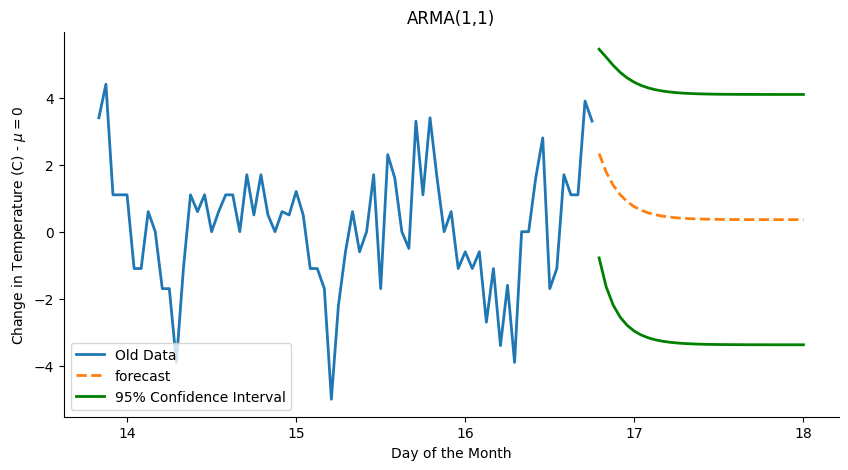

In [7]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load in data
    weather = np.load(filename)
    
    # Get the differences in the days
    z_i = np.diff(weather)
    k = len(z_i)
    
    # Get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    
    # Get the mus and covs from the Kalman Filter
    mus, covs = kalman(F, Q, H, z_i - np.ones_like(z_i) * mu)
    
    # Initialize new mus and covs
    new_mus = np.zeros(n + 1)
    new_covs = np.zeros(n + 1)
    
    # Update step
    y_sim = z_i[-1] - H @ mus[-1]
    S_k = H @ covs[-1] @ H.T
    K_k = covs[-1] @ H.T @ np.linalg.inv(S_k)
    x_k = [mus[-1] + K_k @ y_sim]
    P_k = [(np.eye(dim_states) - K_k @ H) @ covs[-1]]
    
    # Convert mus, covs back to observation state (mu and cov in equation 25.20)
    new_mus[0] = H @ mus[-1] + mu
    new_covs[0] = H @ covs[-1] @ H.T
    
    # Iteratively predict
    for i in range(n):
        # Predict
        x_k.append(F @ x_k[i])
        P_k.append(F @ P_k[i] @ F.T + Q)
        
        # Convert back to observation space
        new_mus[i + 1] = H @ x_k[i + 1] + mu
        new_covs[i + 1] = H @ P_k[i + 1] @ H.T
    
    # Plot results.
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
    ax.plot(z_i, label='Old Data', lw=2)
    ax.plot(range(k, k + n), new_mus[1:], '--', label='forecast', lw=2)
    ax.plot(range(k, k + n), new_mus[1:] + 2 * np.sqrt(new_covs[1:]), 'g', label='95% Confidence Interval', lw=2)
    ax.plot(range(k, k + n), new_mus[1:] - 2 * np.sqrt(new_covs[1:]), 'g', lw=2)
    ax.set_title('ARMA(1,1)')
    ax.set_xlabel('Day of the Month')
    ax.set_ylabel(r'Change in Temperature (C) - $\mu = 0$')
    ax.set_xticks([4 + 24 * i for i in range(5)], [14, 15, 16, 17, 18])
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='lower left')
    plt.plot()

phis, thetas, mu, std = np.array([0.72135856]), np.array([-0.26246788]), 0.35980339870105321, 1.5568331253098422
arma_forecast(filename='weather.npy', phis=phis, thetas=thetas, mu=mu, std=std, n=30)

## Problem 5

272.7341332617096

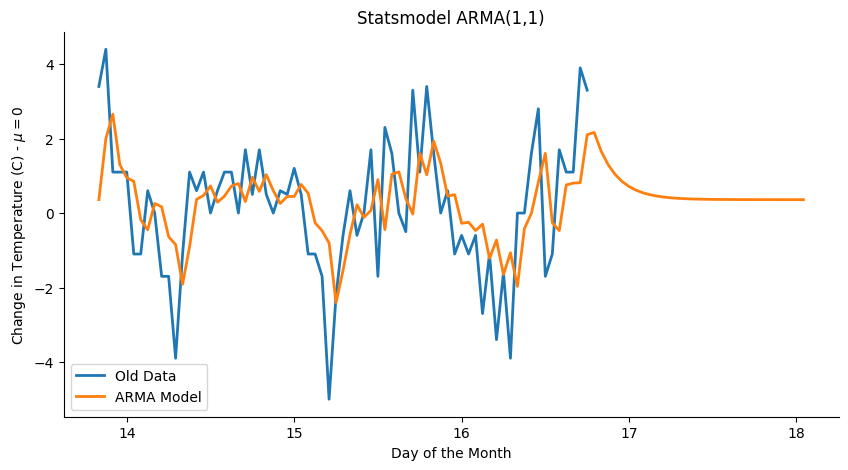

In [8]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # Read in the data and process it.
    weather = np.load(filename)
    z_i = np.diff(weather)
    k = len(z_i)
    
    # Find all combinations of p and q
    pq = list(product(range(1, p_max + 1), range(1, q_max + 1)))
    
    # Initialize best AIC value and parameters
    best_aic = np.inf
    best_p = None
    best_q = None
    best_model_fit = None
    
    # Iterate through all combinations of p and q
    for p, q in pq:
        # Get ARIMA model
        model = ARIMA(z_i, order=(p, 0, q))
        
        # Fit ARIMA model
        try:
            model_fit = model.fit(method='innovations_mle')
            
            # Get AIC
            curr_aic = model_fit.aic
            
            # Update best AIC and parameters if necessary
            if curr_aic < best_aic:
                best_aic = curr_aic
                best_p = p
                best_q = q
                best_model_fit = model_fit
        except:
            # Skip this combination if fitting fails
            continue
    
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
    ax.plot(z_i, label='Old Data', lw=2)
    ax.plot(best_model_fit.predict(start=0, end=len(z_i) + n), label='ARMA Model', lw=2)
    ax.set_title('Statsmodel ARMA(1,1)')
    ax.set_xlabel('Day of the Month')
    ax.set_ylabel(r'Change in Temperature (C) - $\mu = 0$')
    ax.set_xticks([4 + 24 * i for i in range(5)], [14, 15, 16, 17, 18])
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='lower left')
    plt.plot()
    
    return best_aic

sm_arma()

## Problem 6

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  freq = to_offset(freq)
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


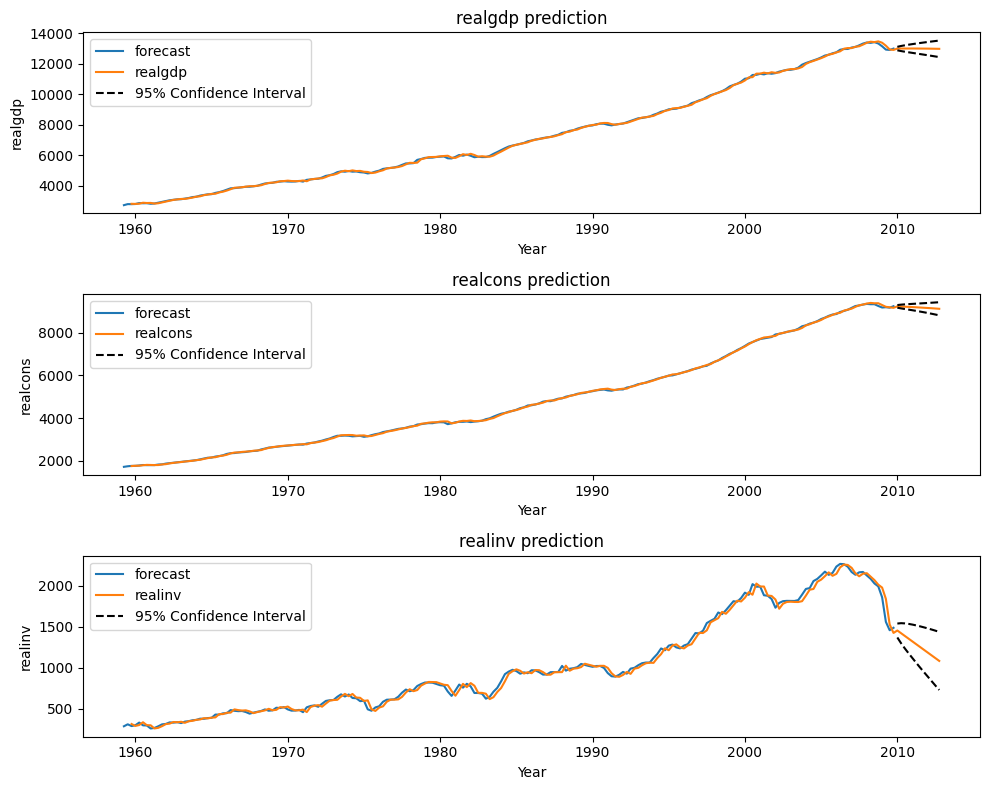

5973.226276443385

In [11]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    # Load in the data and process it for VARMAX
    df = sm.datasets.macrodata.load_pandas().data
    
    # Convert year and quarter to datetime index
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates['year'] + 'Q' + dates['quarter']
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    
    # Drop year and quarter columns and keep only the relevant columns
    df = df[['realgdp', 'realcons', 'realinv']]
    
    # Fit VARMAX model to the data and get predictions
    model = VARMAX(df, freq='Q-DEC')
    model = model.fit(maxiter=1000, disp=False)
    
    #  Get predictions from start to end date
    pred = model.predict(start=start, end=end)
    
    # Get confidence intervals for the forecast and plot
    forecast_obj = model.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)
    
    # Plot the results of the forecast and the confidence intervals
    fig, ax = plt.subplots(3, 1, figsize=(10,8), dpi=100)
    for i, col in enumerate(['realgdp', 'realcons', 'realinv']):
        ax[i].plot(df[col], label='forecast')
        ax[i].plot(pred[col], label=col)
        ax[i].plot(all_CI[f'lower {col}'], 'k--', label='95% Confidence Interval')
        ax[i].plot(all_CI[f'upper {col}'], 'k--')
        ax[i].set_title(f'{col} prediction')
        ax[i].set_xlabel('Year')
        ax[i].set_ylabel(col)
        ax[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return model.aic

sm_varma()